# Stroke Prediction via Bayesian Networks
According to the World Health Organization, stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths and long-term disability. Given the often sudden and devastating nature of stroke events, the most effective clinical strategy is primary prevention, identifying and managing risk in individuals before a catastrophic event occurs. This requires a nuanced understanding of the factors that contribute to stroke risk.  
The goal of this project is therefore not only to predict stroke, but also to model the landscape of contributing factors in an interpretable way, using Bayesian Networks to perform probabilistic inference and answer critical clinical questions.

## Data and Preprocessing

### Stroke Prediction Dataset
The data are used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.  

Dataset provided by *fedesoriano* on Kaggle:  
*Stroke Prediction Dataset*. Available [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data). 

##### Attribute Information
1. id: unique identifier  
2. gender: "Male", "Female" or "Other"  
3. age: age of the patient  
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension  
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease  
6. ever_married: "No" or "Yes"  
7. work_type: "Children", "Govt_jov", "Never_worked", "Private" or "Self-employed"  
8. Residence_type: "Rural" or "Urban"  
9. avg_glucose_level: average glucose level in blood (average between fasting and after eating glucose levels)  
10. bmi: body mass index  
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*  
12. stroke: 1 if the patient had a stroke or 0 if not  
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient.

### Preprocessing steps

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import ExpertKnowledge, HillClimbSearch, BIC, BDeu, AIC, TreeSearch, MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.independencies import IndependenceAssertion
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTENC

Let's take a look at some entries of the dataset and its shape.

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
print(f'Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')
df.head()

Dataset contains 5110 rows and 12 columns.


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


And let's check if there are any columns with missing values.

In [5]:
for col in df.columns:
    num_missing = df[col].isnull().sum()
    if num_missing > 0:
        print(f"{col}: {num_missing} missing values")

bmi: 201 missing values


For the categorical variables gender, work_type and smoking_status, I want to check the distributions to see if there are rare categories that may cause problems due to sparsity.

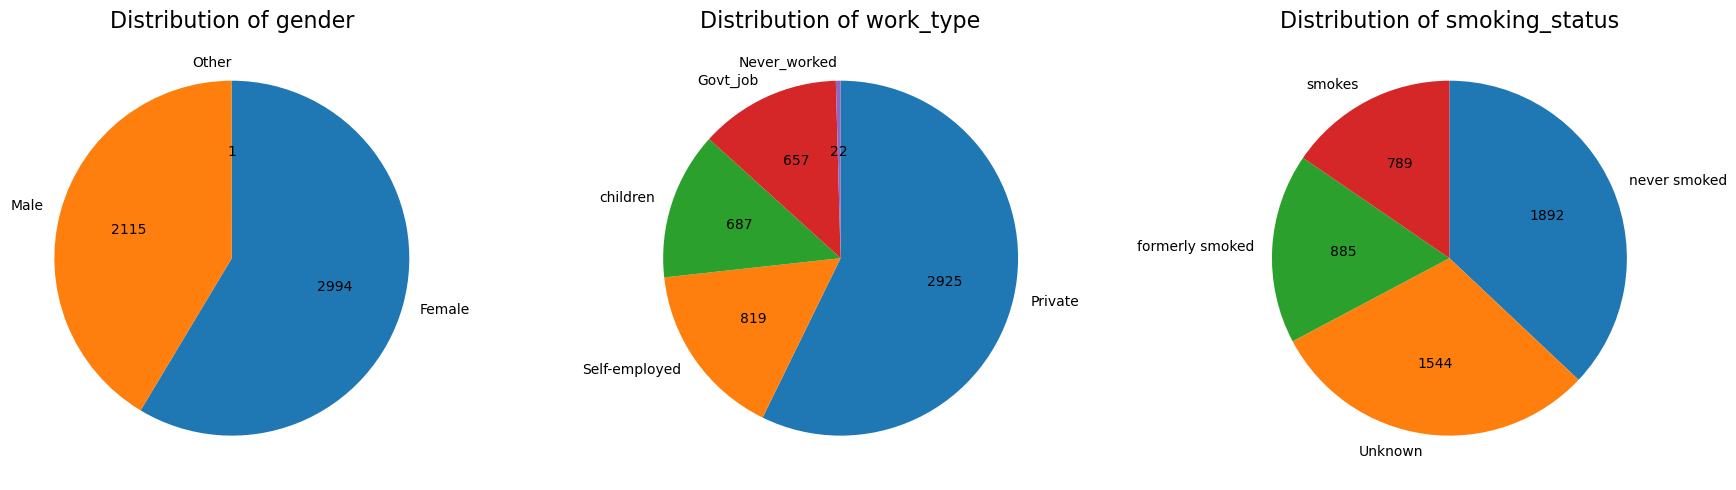

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
variables = ['gender', 'work_type', 'smoking_status']

for i, var in enumerate(variables):
    df[var].value_counts().plot.pie(
        ax=axes[i],
        labels=df[var].value_counts().index,
        autopct=lambda p: f"{int(round(p * df[var].count() / 100))}",
        startangle=90,
        counterclock=False,
        legend=False
    )
    axes[i].set_ylabel('')
    axes[i].set_title(f'Distribution of {var}', fontsize=16)

plt.tight_layout()
plt.show()

I will drop the non-informative column id and all rows containing a missing BMI value, as well as the row with gender value equal to 'Other' and all of the rows with unknown smoking status.  
The Never_worked category will be kept to keep the dataset faithful to the real-world population. It could as well be meaningful in rare or edge-case clinical profiles (e.g., individuals with lifelong disability, severe illness, etc.).

In [3]:
df_clean = df[(df['smoking_status'] != 'Unknown') & (df['gender'] != 'Other')].drop(columns=['id']).dropna()
print(f'Dataset contains {df_clean.shape[0]} rows and {df_clean.shape[1]} columns.')
df_clean.head()

Dataset contains 3425 rows and 11 columns.


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


Let's look at the distribution of the variables after cleaning the dataset.

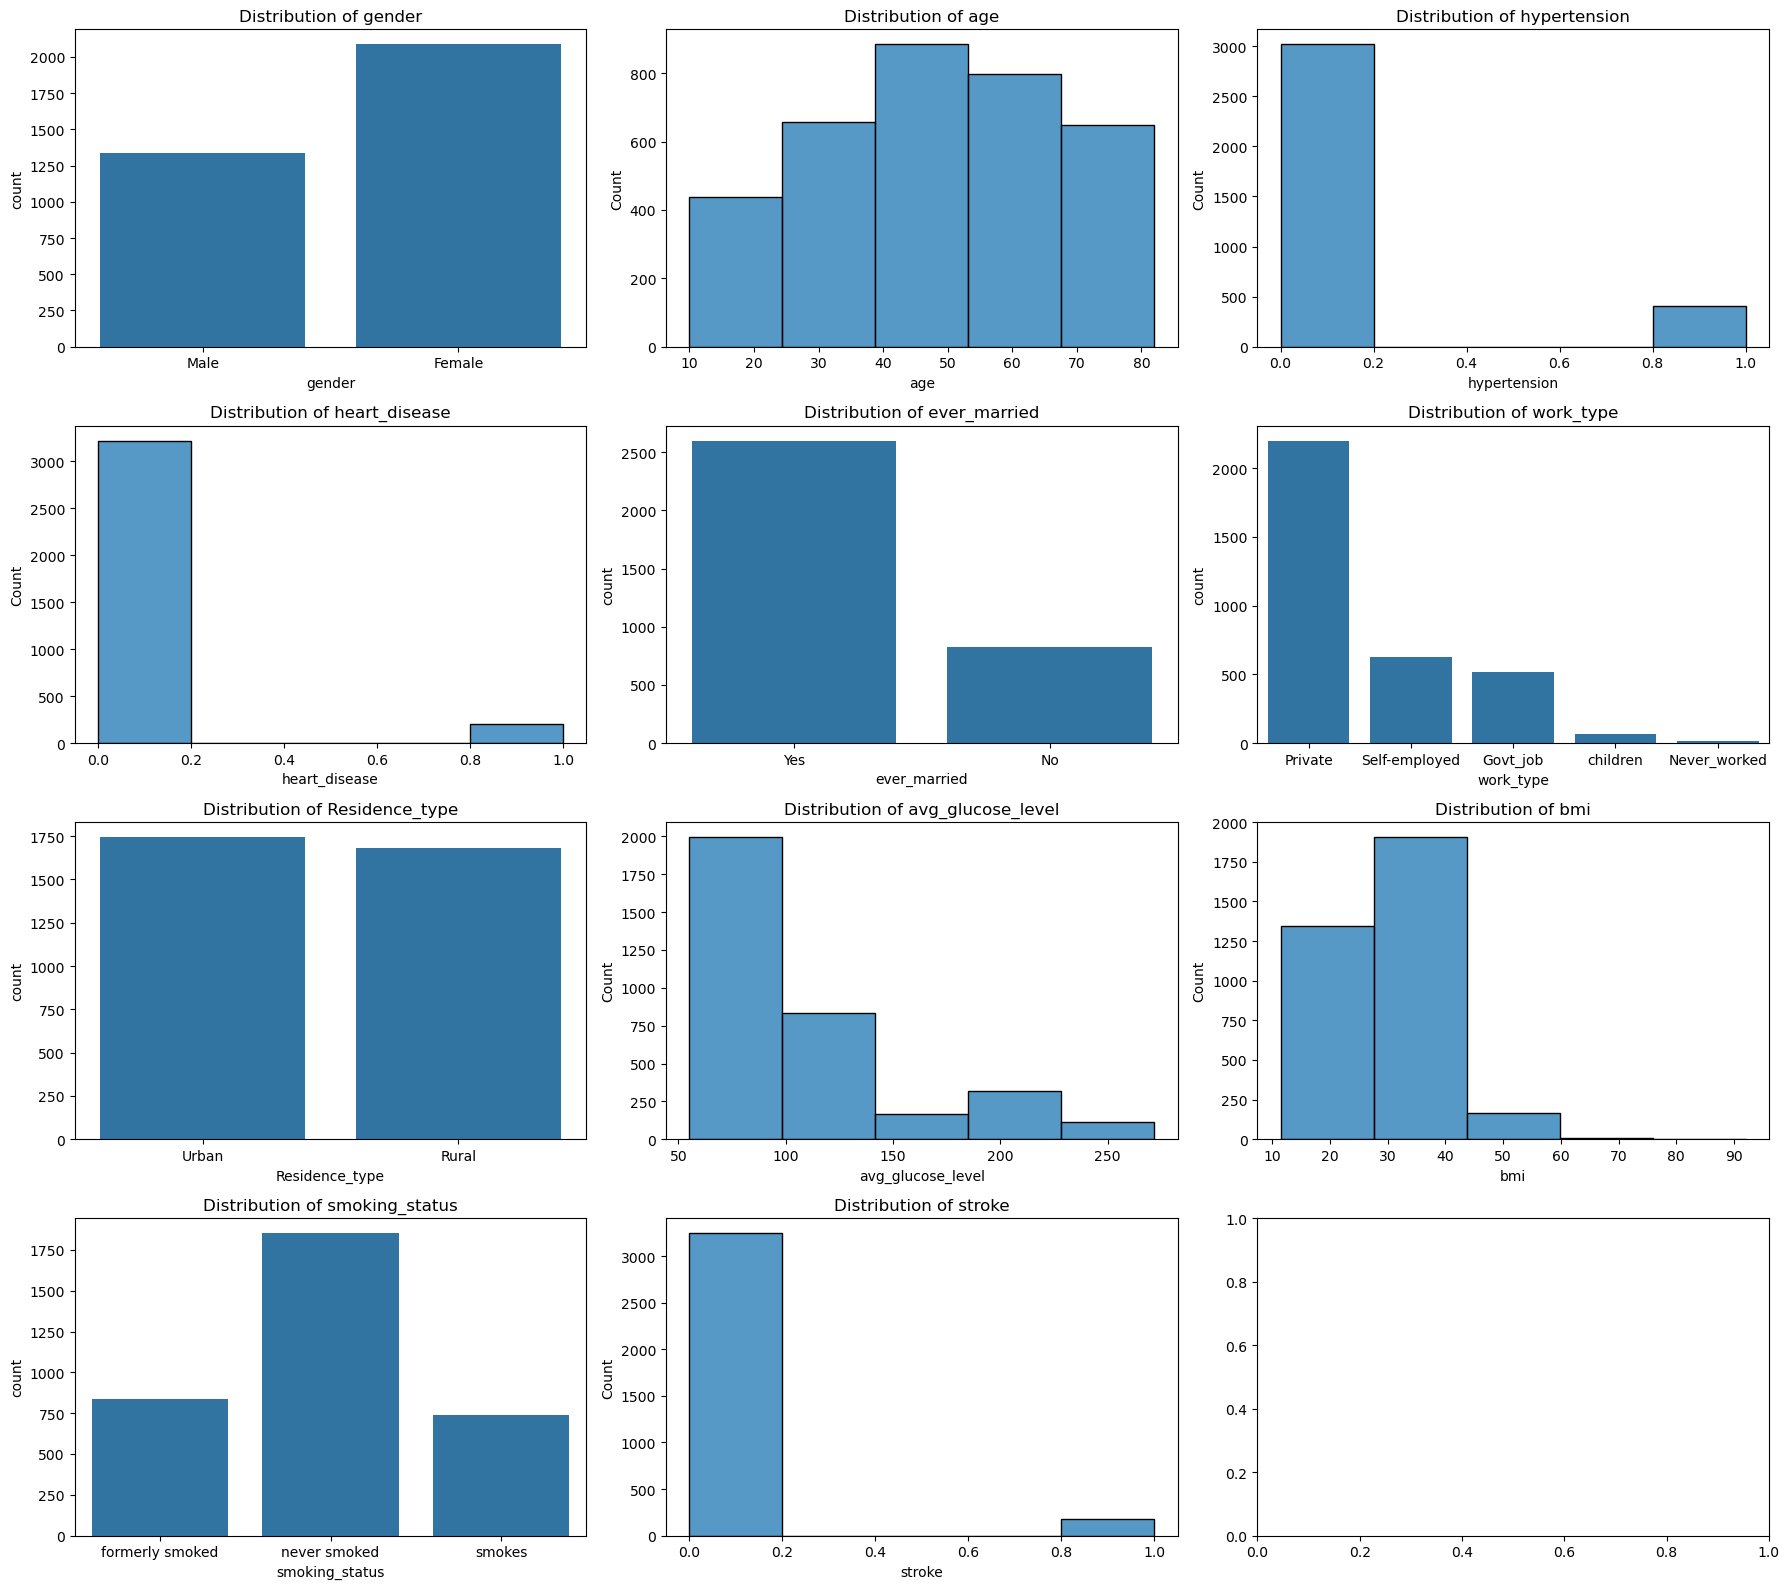

In [13]:
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()
feature_cols = df_clean.columns.tolist()
for i, col in enumerate(feature_cols):
    if df_clean[col].dtype == 'object':
        sns.countplot(x=col, data=df_clean, ax=axes[i])
    else:
        sns.histplot(df_clean[col], bins=5, kde=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

The target variable stroke is strongly unbalanced, with a large majority of cases labeled as "no stroke". This imbalance could bias the model toward predicting the majority class, reducing its ability to detect actual stroke cases.  
To address this, one can undersample the majority class or oversample the minority one. Undersampling the majority class, though, will lead to a huge information loss since there are **less than 200 stroke cases**. I'll instead oversample the stroke cohort to obtain a more balanced dataset.  
The fastest way would be drawing with replacement from the minority class, but this would most likely lead to overfitting to the few available minority samples and failing to introduce diversity in the synthetic data, with combinations of features being sparse or non-representative.  
For this reason I'll use the **SMOTE (Synthetic Minority Over-sampling Technique)** algorythm. SMOTE generates new synthetic examples by interpolating between existing minority class samples and their nearest neighbors. For each sample, it selects one or more of its k-nearest neighbors and creates new samples along the line segment connecting them. I'll use **SMOTE-NC (SMOTE for Nominal and Continuous features)**, specifically designed for mixed-type datasets.

In [4]:
X = df_clean.drop('stroke', axis=1)
y = df_clean['stroke']

categorical_cols = [
    'gender',
    'hypertension',
    'heart_disease',
    'ever_married',
    'work_type',
    'Residence_type',
    'smoking_status'
]

encoder = OrdinalEncoder()
# Only encode the categorical non-binary columns
non_binary_cats = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
X[non_binary_cats] = encoder.fit_transform(X[non_binary_cats])

categorical_indices = [X.columns.get_loc(col) for col in categorical_cols]

smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.Series(y_resampled, name='stroke')

X_resampled_df[non_binary_cats] = encoder.inverse_transform(X_resampled_df[non_binary_cats])

df_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# PREVIOUSLY USED CODE FOR UPSAMPLING
# df_majority = df_clean[df_clean['stroke'] == 0]
# df_minority = df_clean[df_clean['stroke'] == 1]

# df_minority_upsampled = df_minority.sample(n=len(df_majority), replace=True, random_state=42)

# df_resampled = pd.concat([df_majority, df_minority_upsampled], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

Let's take a look at the data and its shape after upsampling.

In [21]:
print(f'Dataset contains {df_resampled.shape[0]} rows and {df_resampled.shape[1]} columns.')
df_resampled.head()

Dataset contains 6490 rows and 11 columns.


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,79.00363,0,0,Yes,Private,Rural,185.832395,29.745916,never smoked,1
1,Female,78.41306,0,0,Yes,Private,Urban,66.466978,25.488079,never smoked,1
2,Female,49.00000,0,0,Yes,Govt_job,Rural,83.840000,19.300000,formerly smoked,0
3,Female,26.00000,0,0,No,Private,Urban,82.610000,28.500000,smokes,0
4,Male,51.00000,0,0,Yes,Private,Rural,232.640000,45.200000,never smoked,0


We should now convert age to integer, and round avg_glucose_level and BMI to 2 and 1 decimal digits respectively, to make them realistic.

In [5]:
df_resampled['age'] = df_resampled['age'].round().astype(int)
df_resampled['avg_glucose_level'] = df_resampled['avg_glucose_level'].round(2)
df_resampled['bmi'] = df_resampled['bmi'].round(1)

Let's look at the distributions again.

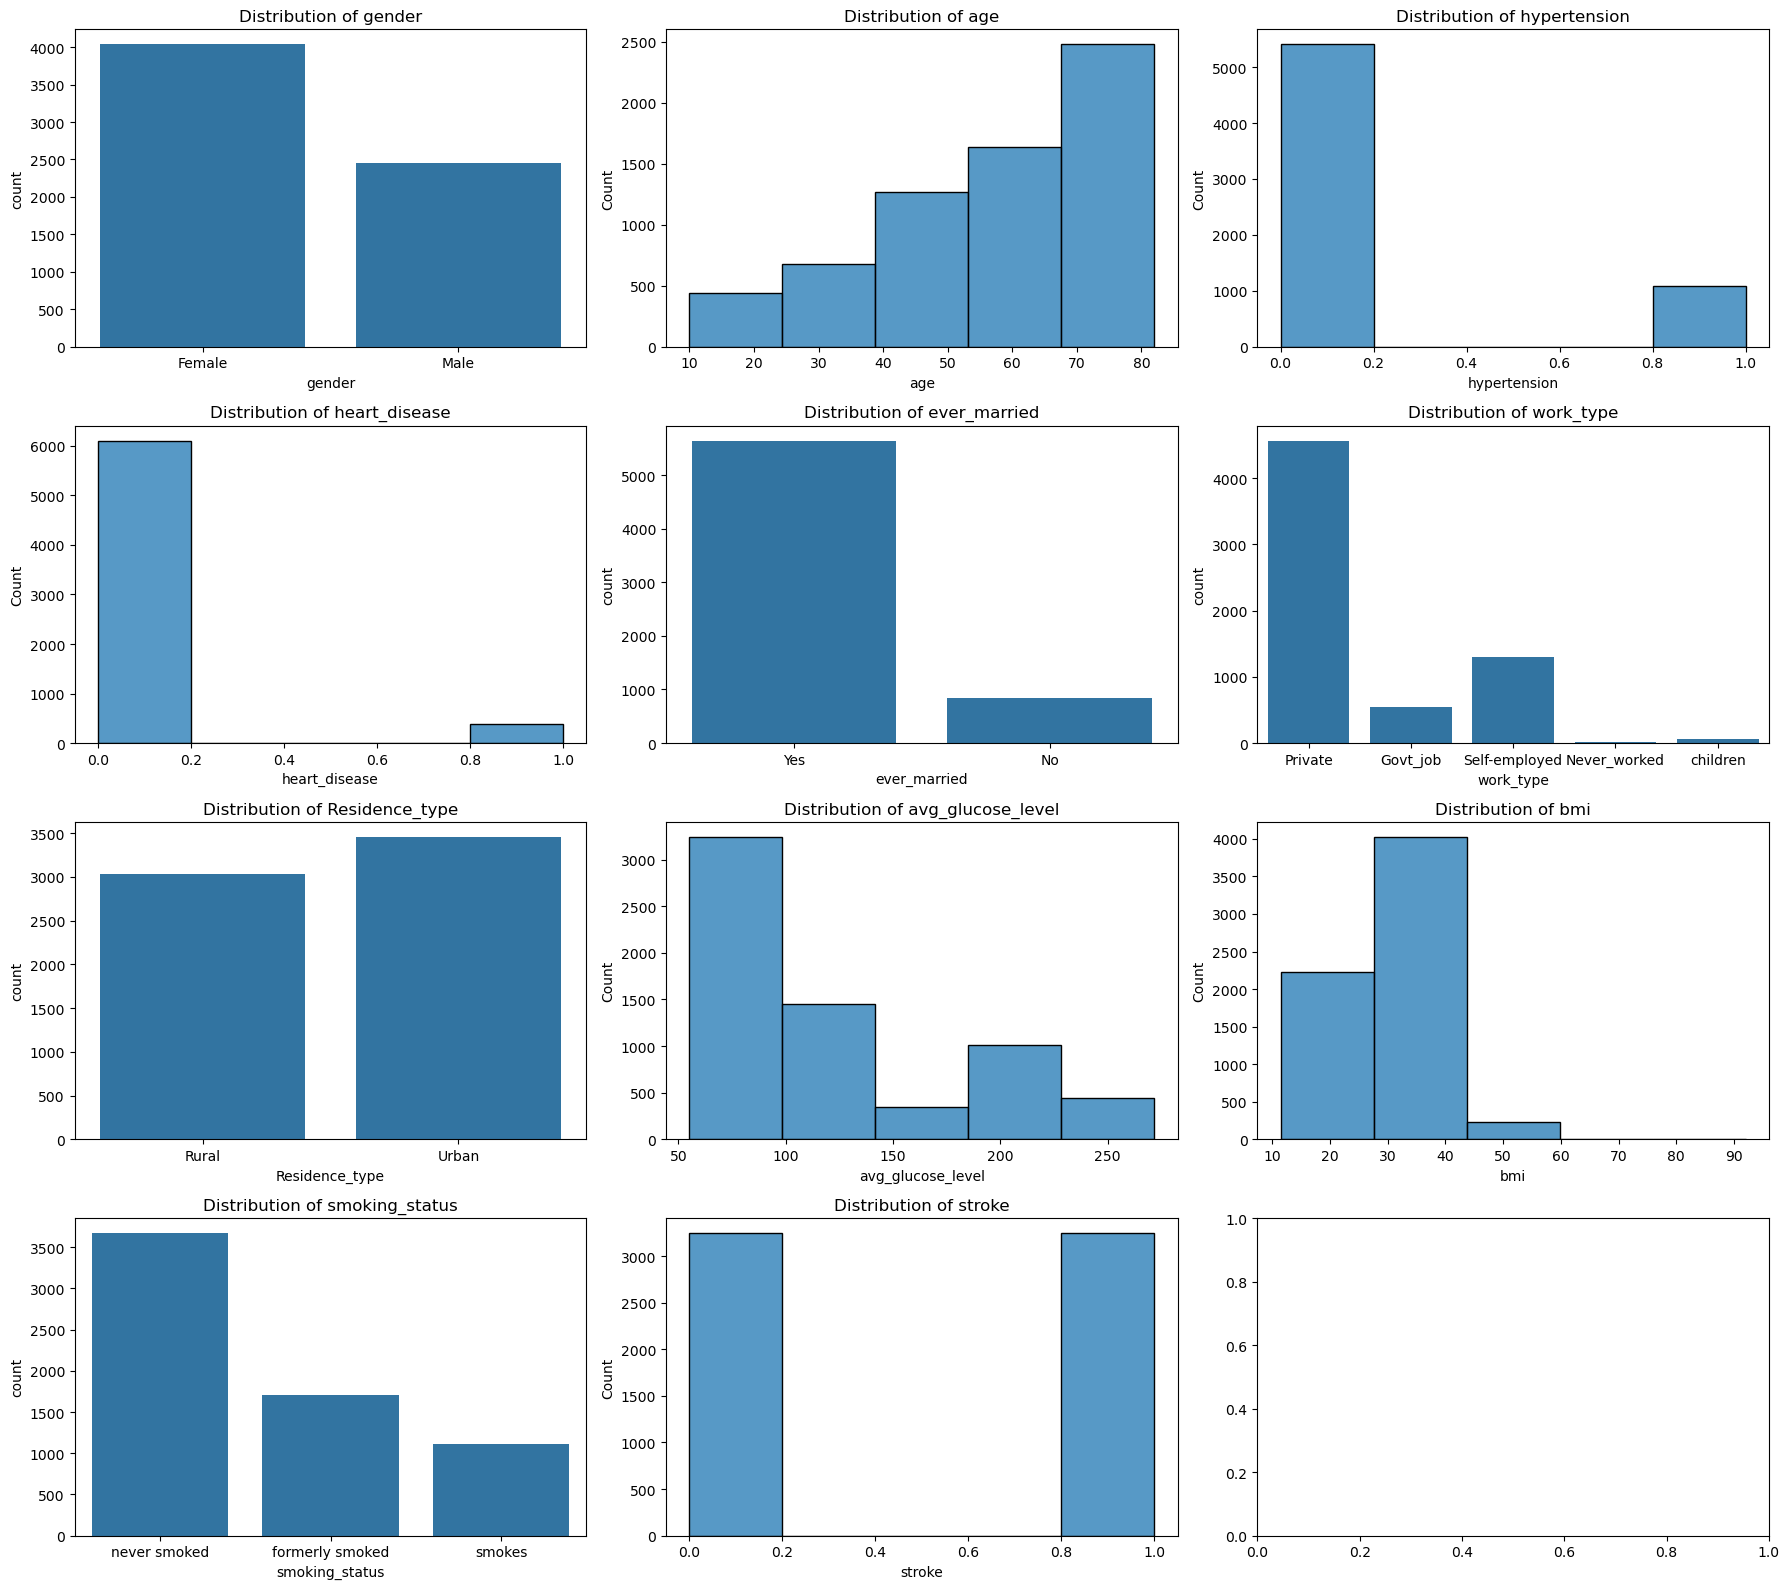

In [23]:
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()
feature_cols = df_resampled.columns.tolist()
for i, col in enumerate(feature_cols):
    if df_resampled[col].dtype == 'object':
        sns.countplot(x=col, data=df_resampled, ax=axes[i])
    else:
        sns.histplot(df_resampled[col], bins=5, kde=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

Apart from the perfect balance in the stroke variable, there are a couple of things worth noticing.  
* **age:** There’s a stronger skew toward older age groups, likely because stroke cases are more common among older individuals.  
* **hypertension and heart_disease**: Slight increase in the relative frequency for positive cases (1), consistent with higher prevalence in the upsampled stroke group.  
* **ever_married:** Slight increase in the relative frequency of ever married individuals.  
* **avg_glucose_level:**: Slight increase in frequency for high-values bins, reflecting higher glucose levels among stroke cases.  

The observed changes in the distributions of *age*, *hypertension*, *heart_disease* and *avg_glucose_level*, reflect expected associations between stroke and its risk factors ([CDC](https://www.cdc.gov/stroke/risk-factors/index.html)). These shifts are a natural outcome of SMOTE-NC and do not imply that the synthetic data are unrepresentative of the population.  
Regarding the *ever_married* variable, it should be noted that while [literature](https://www.keele.ac.uk/research/researchnews/2018/june/marriagemayprotectagainstheartdiseaseandstroke/marriage.php#:~:text=A%20global%20study%20led%20by,survival%20in%20its%20own%20right.) suggests that marital status can influence stroke risk, with single, widowed, or divorced individuals generally at higher risk, the binary encoding in this dataset (ever married vs. never married) does not allow for a clear interpretation of this shift.

## Baseline classifier for stroke prediction
For properly evaluating the BNs, a *Decision Tree Classifier* is implemented and will serve as baseline ML model. The models will be evaluated on stroke prediction.  
The chosen baseline is a fast, yet strong model for the binary classification task at hand. Before training it, the categorical variables with more than 2 categories have been one-hot encoded, while the numerical features have been standardized.  
To avoid overfitting, the maximum depth is set to 10.

Accuracy: 0.8659476117103235
F1 Score: 0.873546511627907
Precision: 0.8266850068775791
Recall: 0.926040061633282


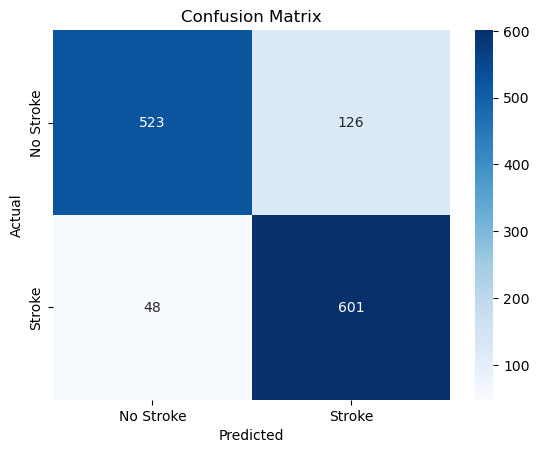

In [30]:
# Encoding binary variables
df_encoded = df_resampled.copy()
df_encoded['gender'] = df_encoded['gender'].map({'Male': 0, 'Female': 1})
df_encoded['ever_married'] = df_encoded['ever_married'].map({'No': 0, 'Yes': 1})
df_encoded['Residence_type'] = df_encoded['Residence_type'].map({'Urban': 0, 'Rural': 1})

X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

categorical_cols = ['work_type', 'smoking_status']
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
binary_cols = ['gender', 'ever_married', 'Residence_type', 'hypertension', 'heart_disease']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ],
    remainder='passthrough'  # keeps binary columns unmodified
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=10, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42  # stratification ensures same class distribution in train and test sets
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

accuracy, f1, prec, rec = accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", prec)
print("Recall:", rec)

confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The performance of the decision tree is pretty good with an accuracy score of 0.87 on the test set.  
Specifically, the model catches stroke when it's present 93% of the time (recall score 0.926) and among all the stroke predictions 83% of them are correct (precision score 0.827).

## Bayesian Networks implementation
In this section, three Bayesian Networks are implemented and compared by evaluating them on binary stroke prediction. For proper evaluation, they will also be compared with the baseline model previously defined.  
The best BN will then be selected for analysing its structure and, more importantly, to make probabilistic inference by running clinically relevant queries.

### Discretization of the numerical variables
Several BNs will be implemented by using the *DiscreteBayesianNetwork* class of the *pgmpy* library. For this reason, the numerical variables need to be discretized. There are several approaches for doing so, that can be grouped as follows:  
* **Unsupervised methods:** These techniques ignore the target (stroke), e.g., equal-width, equal-frequency, k-means, and are most suited when the focus is on probabilistic reasoning (causal discovery, belief updating, etc.).  
* **Supervised methods:** Consider the target when discretizing, (e.g., MDLP, entropy-based), most suited when the primary task is prediction.  

I experimented with both euqal-frequency binning and supervized entropy-based discretization. The latter tries to minimize class entropy within bins. It finds the best binning thresholds for each continuous feature by splitting where the class labels (stroke) are most "pure", which is essentially what decision trees do internally.  
The experimental results (not shown for conciseness) proved that equal-frequency binning results in slightly better classification accuracy.

In [6]:
def discretize_feature_supervised(series, target, max_leaf_nodes=4):
    """
    Discretize a feature using supervised entropy-based binning with a decision tree.
    Returns: categorical Series, bin edges
    """
    X = series.values.reshape(-1, 1)
    y = target.values

    tree = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=42)
    tree.fit(X, y)

    thresholds = np.sort(tree.tree_.threshold[tree.tree_.threshold != -2])
    binned = np.digitize(series, bins=thresholds, right=False)
    return pd.Series(binned, index=series.index, dtype='category'), thresholds

def discretize_feature_quantile(series, q=4):
    """
    Discretize a feature using equal-frequency (quantile) binning.
    Returns: categorical Series, bin edges
    """
    bins = pd.qcut(series, q=q, duplicates='drop')
    bin2int = {interval: i for i, interval in enumerate(bins.cat.categories)}
    binned = bins.apply(lambda x: bin2int[x])
    thresholds = [interval.left for interval in bins.cat.categories] + [bins.cat.categories[-1].right]
    return pd.Series(binned, index=series.index, dtype='category'), thresholds

def discretize_variables(df, variables, target, strategy='quantile', **kwargs):
    """
    Discretize multiple numerical variables in the DataFrame.
    Supports 'supervised' and 'quantile' strategies.
    Returns: modified DataFrame and bin label dictionary.
    """
    df_binned = df.copy()
    bin_edges_dict = {}

    for col in variables:
        series = df[col].astype(float)

        if strategy == 'supervised':
            binned_col, edges = discretize_feature_supervised(series, df[target], **kwargs)
        elif strategy == 'quantile':
            binned_col, edges = discretize_feature_quantile(series, **kwargs)
        else:
            raise ValueError(f"Unknown strategy: {strategy}")

        # Assign discretized column
        df_binned[col] = binned_col

        # Construct bin labels
        edges = [series.min()] + list(edges) if edges[0] > series.min() else list(edges)
        edges = edges + [series.max()] if edges[-1] < series.max() else edges
        edges = sorted(set(edges))  # Remove duplicates, sort

        bin_labels = {
            i: f"[{edges[i]:.2f}, {edges[i+1]:.2f})" for i in range(len(edges) - 1)
        }
        bin_edges_dict[col] = bin_labels

    return df_binned, bin_edges_dict

def print_bin_ranges(col, dict):
    """    
    Print the bin ranges for a given column from the bin_edges_dict.
    """
    if col in dict:
        print(f"Bin ranges for '{col}':")
        for bin_idx, label in dict[col].items():
            print(f"  Bin {bin_idx}: {label}")
    else:
        print(f"No bin ranges found for column '{col}'.")

In [7]:
df_binned, bin_edges_dict = discretize_variables(
    df_resampled,
    variables=['age', 'avg_glucose_level', 'bmi'],
    target='stroke',
    strategy='quantile',
    q=4
)

Let's see the bin ranges of the discretized variables.

In [52]:
print_bin_ranges('age', bin_edges_dict)
print_bin_ranges('avg_glucose_level', bin_edges_dict)
print_bin_ranges('bmi', bin_edges_dict)

Bin ranges for 'age':
  Bin 0: [10.00, 46.00)
  Bin 1: [46.00, 60.00)
  Bin 2: [60.00, 74.00)
  Bin 3: [74.00, 82.00)
Bin ranges for 'avg_glucose_level':
  Bin 0: [55.12, 78.64)
  Bin 1: [78.64, 98.47)
  Bin 2: [98.47, 171.60)
  Bin 3: [171.60, 271.74)
Bin ranges for 'bmi':
  Bin 0: [11.50, 26.20)
  Bin 1: [26.20, 29.50)
  Bin 2: [29.50, 33.70)
  Bin 3: [33.70, 92.00)


The discretized numerical variables and the binary variables encoded as integers will be converted to categorical to be handled by the pgmpy class.

In [8]:
# Convert binned variables to categorical
for col in ['age', 'avg_glucose_level', 'bmi']:
    df_binned[col] = df_binned[col].astype('category')

# Convert binary variables encoded as integers to categorical
binary_cols = ['hypertension', 'heart_disease', 'stroke']
df_binned[binary_cols] = df_binned[binary_cols].astype('category')

### BNs structure design

#### Custom design
The first network's structure will be designed exploiting domain knowledge in the medical field, common sense and statistical insights.  

First of all, according to well-established medical knowledge, age, gender, hypertension, heart diseases, obesity (thus BMI), smoking and diabetes*, among others, are all [risk factors for stroke](https://www.cdc.gov/stroke/risk-factors/index.html). Moreover, as mentioned above, the marital status has an impact on stroke incidence. The work type can be linked to stroke due to its direct effects on working hours, anxiety, depression, lifestyle and stress, which may all rise the risk for sroke ([NIH](https://www.nhlbi.nih.gov/health/stroke/causes)). It's also been observed that there are [rural-urban differences in stroke risk](https://pmc.ncbi.nlm.nih.gov/articles/PMC8545748/#S8), whereas living in a rural area is associated with a higher overall risk.  

Age, diabetes (hence high glucose levels), obesity (hence BMI) and smoking, among others, are [risk factors for hypertension](https://www.cdc.gov/high-blood-pressure/risk-factors/index.html).  

Hypertension, smoking, glucose levels, BMI and age are [risk factors for heart diseease](https://www.cdc.gov/heart-disease/risk-factors/index.html). Moreover, gender may influence the risk for heart disease through [women-specific factors](https://www.sciencedirect.com/science/article/pii/S2590093519300256#sec5).  

Age, BMI and smoking are some of the [risk factors for diabetes](https://www.cdc.gov/diabetes/risk-factors/index.html), thus they have a direct influence on the average glucose level in the blood. Gender too can influence the glucose levels if a woman experiences gestational diabetes.  

There have been observed [gender-related differences in obesity](https://pmc.ncbi.nlm.nih.gov/articles/PMC11242171/#sec2-ijms-25-07342), suggesting that gender can have an influence on BMI values. Also it's reasonable to assess that changes in body composition and height with age can affect BMI. Specifically, older adults tend to lose muscle mass (sarcopenia) and may experience height loss, which can lead to an increase in BMI.  

Age clearly influences the smoking status as adults are more likely to smoke with respect to kids. It's also common knowledge that smoking prevalence is higher among adult men than adult women. For obvious reasons, age also affects directly the marital status and the work type.  

In order to understand if there is any association between demographic variables, Chi2 test for independence is performed between the following pairs of variables: (*age*, *Residence_type*), (*gender*, *ever_married*), (*gender*, *work_type*), (*gender*, *Residence_type*).  

*Diabetes causes sugars to build up in the blood and high glucose levels can damage blood vessels over time, making them more susceptible to the formation of clots or blockages that can trigger a stroke ([ASO](https://www.stroke.org/en/help-and-support/resource-library/lets-talk-about-stroke/diabetes)).

In [9]:
# Define pairs of variables to test
pairs = [
    ('age', 'Residence_type'),
    ('gender', 'ever_married'),
    ('gender', 'work_type'),
    ('gender', 'Residence_type')
]

for var1, var2 in pairs:
    contingency_table = pd.crosstab(df_binned[var1], df_binned[var2])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"\nChi-square test between {var1} and {var2}")
    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"p-value: {p:.4f}")
    if p < 0.05:
        print(f"There is a significant association between {var1} and {var2}.")
    else:
        print(f"There is no significant association between {var1} and {var2}.")


Chi-square test between age and Residence_type
Chi-square statistic: 8.54
p-value: 0.0361
There is a significant association between age and Residence_type.

Chi-square test between gender and ever_married
Chi-square statistic: 0.59
p-value: 0.4409
There is no significant association between gender and ever_married.

Chi-square test between gender and work_type
Chi-square statistic: 18.44
p-value: 0.0010
There is a significant association between gender and work_type.

Chi-square test between gender and Residence_type
Chi-square statistic: 4.07
p-value: 0.0436
There is a significant association between gender and Residence_type.


Text(0.5, 1.0, 'Custom model')

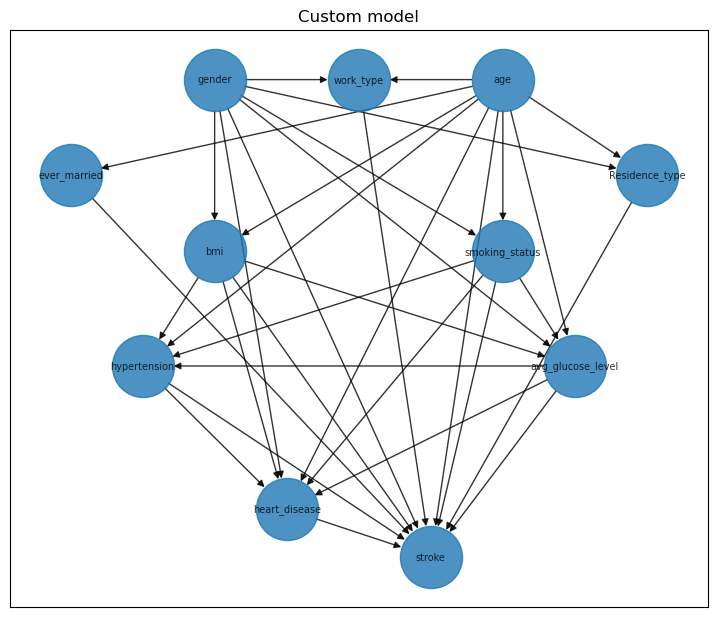

In [10]:
# Rimossi: gender -> hypertension; gender -> ever_married
# Aggiunti: avg_glucose_level -> hypertension; smoking_status -> avg_glucose_level; gender -> Residence_type

edges = [('gender', var) for var in ['Residence_type', 'work_type']]
edges += [('age', var) for var in ['ever_married', 'work_type', 'Residence_type']]
edges += [(var, 'smoking_status') for var in ['age', 'gender']]
edges += [(var, 'bmi') for var in ['age', 'gender']]
edges += [(var, 'hypertension') for var in ['age', 'bmi', 'smoking_status', 'avg_glucose_level']]
edges += [(var, 'heart_disease') for var in ['age', 'gender', 'hypertension', 'avg_glucose_level', 'bmi', 'smoking_status']]
edges += [(var, 'avg_glucose_level') for var in ['age', 'gender', 'bmi', 'smoking_status']]
edges += [(var, 'stroke') for var in ['age', 'gender', 'ever_married', 'work_type', 'Residence_type', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status']]

custom_model = DiscreteBayesianNetwork(edges)

# pos = nx.nx_agraph.graphviz_layout(custom_model, prog = "dot")  #!!Gives OS error
pos = {'gender': [-1, 2], 'work_type': [0, 2], 'age': [1, 2],
       'ever_married': [-2, 1], 'Residence_type': [2, 1],
       'bmi': [-1, 0.2], 'smoking_status': [1, 0.2],
       'hypertension': [-1.5, -1], 'avg_glucose_level': [1.5, -1],
       'heart_disease': [-0.5,  -2.5], 
       'stroke': [0.5, -3]}

fig, ax = plt.subplots(1, 1, figsize=(9, 7.5))
nx.draw_networkx(custom_model, pos=pos, ax=ax, node_size=2000, font_size = 7, alpha = 0.8)
ax.set_title('Custom model')
#fig.savefig('custom_bn')

In [11]:
test_ratio = 0.2
train_data, test_data = train_test_split(df_binned, test_size=test_ratio, random_state=42)
print(f"The shape of the training data is: {train_data.shape} and the shape of the test_data is: {test_data.shape}")

The shape of the training data is: (5192, 11) and the shape of the test_data is: (1298, 11)


In [12]:
custom_model.fit(train_data, estimator=BayesianEstimator, prior_type="BDeu")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'gender': 'C', 'age': 'O', 'hypertension': 'C', 'heart_disease': 'C', 'ever_married': 'C', 'work_type': 'C', 'Residence_type': 'C', 'avg_glucose_level': 'O', 'bmi': 'O', 'smoking_status': 'C', 'stroke': 'C'}


In [34]:
predict_data = test_data.drop(columns = ['stroke'])

label_prediction = test_data['stroke']

data_pred = custom_model.predict(predict_data)
y_pred = data_pred['stroke']

c:\Users\mikec\anaconda3\envs\faikr-3\Lib\site-packages\pgmpy\models\DiscreteBayesianNetwork.py:720: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_unique_indexes = data.groupby(list(data.columns), dropna=False).apply(


  0%|          | 0/763 [00:00<?, ?it/s]

Accuracy: 0.5130970724191063
F1 Score: 0.5047021943573667
Precision: 0.5111111111111111
Recall: 0.4984520123839009


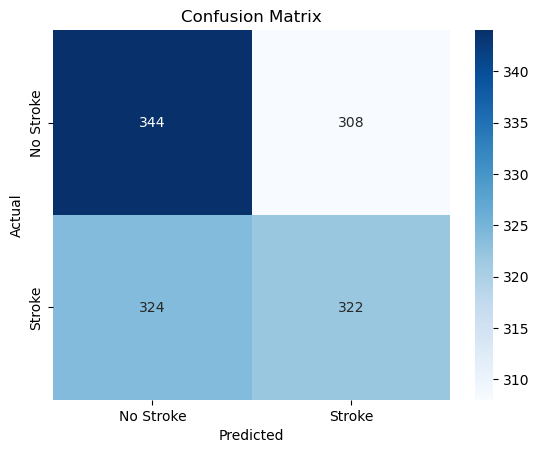

In [35]:
accuracy, f1, prec, rec = (
    accuracy_score(label_prediction, y_pred),
    f1_score(label_prediction, y_pred),
    precision_score(label_prediction, y_pred),
    recall_score(label_prediction, y_pred)
)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", prec)
print("Recall:", rec)

confusion = confusion_matrix(label_prediction, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The accuracy score of 0.51 indicates that the model is barely better than random guessing. The model does not excel at either precision or recall.

#### Structure learning with Hill Climb Search
The next Networks will adopt structure learning, meaning that the edges are built by learning conditional independencies from data.  
*Hill Climb Search* is a heuristic search algorithm that performs local hill climb search to estimates the DAG structure that has optimal score, according to the scoring method supplied (BDeu).  
ExpertKnowledge has been used to specify forbidden edges (i.e. edges from stroke to other features and from any feature to both gender and age).

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'gender': 'C', 'age': 'O', 'hypertension': 'C', 'heart_disease': 'C', 'ever_married': 'C', 'work_type': 'C', 'Residence_type': 'C', 'avg_glucose_level': 'O', 'bmi': 'O', 'smoking_status': 'C', 'stroke': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'gender': 'C', 'age': 'O', 'hypertension': 'C', 'heart_disease': 'C', 'ever_married': 'C', 'work_type': 'C', 'Residence_type': 'C', 'avg_glucose_level': 'O', 'bmi': 'O', 'smoking_status': 'C', 'stroke': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'gender': 'C', 'age': 'O', 'hypertension': 'C', 'heart_disease': 'C', 'ever_married': 'C', 'work_type': 'C', 'Residence_type': 'C', 'avg_glucose_level': 'O', 'bmi': 'O', 'smoking_status': 'C', 'stroke': 'C'}


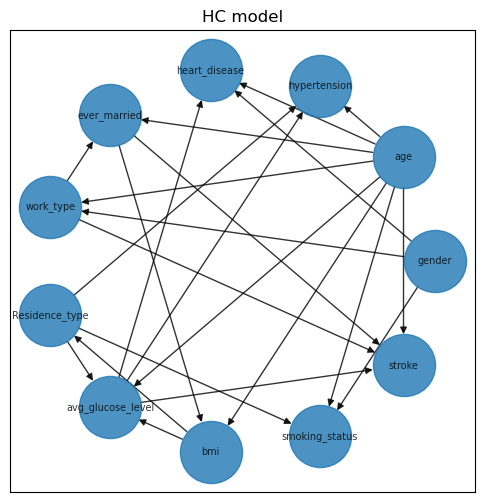

In [64]:
expert_knowledge = ExpertKnowledge()
expert_knowledge.forbidden_edges = [("stroke", node) for node in df_binned.columns if node != "stroke"]
expert_knowledge.forbidden_edges += [(node, 'age') for node in df_binned.columns if node != "age"]
expert_knowledge.forbidden_edges += [(node, 'gender') for node in df_binned.columns if node != "gender"]

hc = HillClimbSearch(df_binned)
HC_DAG = hc.estimate(scoring_method='bdeu', expert_knowledge=expert_knowledge, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(HC_DAG, pos=nx.drawing.layout.circular_layout(HC_DAG), ax=ax, node_size=2000, font_size = 7, alpha = 0.8)
ax.set_title('HC model')

HCmodel = DiscreteBayesianNetwork(HC_DAG.edges())

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'gender': 'C', 'age': 'O', 'hypertension': 'C', 'heart_disease': 'C', 'ever_married': 'C', 'work_type': 'C', 'Residence_type': 'C', 'avg_glucose_level': 'O', 'bmi': 'O', 'smoking_status': 'C', 'stroke': 'C'}


The shape of the training data is: (5192, 11) and the shape of the test_data is: (1298, 11)


c:\Users\mikec\anaconda3\envs\faikr-3\Lib\site-packages\pgmpy\models\DiscreteBayesianNetwork.py:720: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_unique_indexes = data.groupby(list(data.columns), dropna=False).apply(


  0%|          | 0/763 [00:00<?, ?it/s]

Accuracy: 0.5231124807395994
F1 Score: 0.572218382861092
Precision: 0.5168539325842697
Recall: 0.6408668730650154


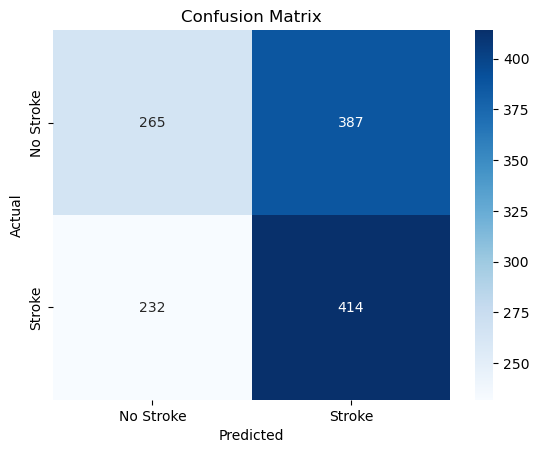

In [65]:
test_ratio = 0.2
train_data, test_data = train_test_split(df_binned, test_size=test_ratio, random_state=42)
print(f"The shape of the training data is: {train_data.shape} and the shape of the test_data is: {test_data.shape}")

HCmodel.fit(train_data, estimator=BayesianEstimator, prior_type="BDeu")

predict_data = test_data.drop(columns = ['stroke'])
label_prediction = test_data['stroke']
data_pred = HCmodel.predict(predict_data)
y_pred = data_pred['stroke']

accuracy, f1, prec, rec = accuracy_score(label_prediction, y_pred), f1_score(label_prediction, y_pred), precision_score(label_prediction, y_pred), recall_score(label_prediction, y_pred)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", prec)
print("Recall:", rec)

confusion = confusion_matrix(label_prediction, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The HC model with structural constraints performs slightly better than the previous model, with an accuracy score of 0.52 and an F1 score of 0.57, explained by the higher recall score. In other words, compared to the custom model, this network is slightly better at catching actual stroke events.

#### Structure learning with Tree Search
The next model will use a tree search algorythm for estimating the best fitting DAG structure. It constructs the maximum-weight spanning tree with mutual information score as edge weights.

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'gender': 'C', 'age': 'O', 'hypertension': 'C', 'heart_disease': 'C', 'ever_married': 'C', 'work_type': 'C', 'Residence_type': 'C', 'avg_glucose_level': 'O', 'bmi': 'O', 'smoking_status': 'C', 'stroke': 'C'}


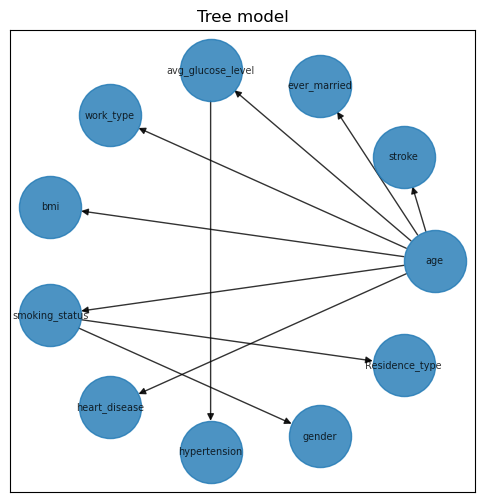

In [87]:
ts = TreeSearch(df_binned, root_node=None)
tree_DAG = ts.estimate(show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(tree_DAG, pos=nx.drawing.layout.circular_layout(tree_DAG), ax=ax, node_size=2000, font_size = 7, alpha = 0.8)
#fig.savefig('tree')
ax.set_title('Tree model')
tree_model = DiscreteBayesianNetwork(tree_DAG.edges())

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'gender': 'C', 'age': 'O', 'hypertension': 'C', 'heart_disease': 'C', 'ever_married': 'C', 'work_type': 'C', 'Residence_type': 'C', 'avg_glucose_level': 'O', 'bmi': 'O', 'smoking_status': 'C', 'stroke': 'C'}


The shape of the training data is: (5192, 11) and the shape of the test_data is: (1298, 11)


c:\Users\mikec\anaconda3\envs\faikr-3\Lib\site-packages\pgmpy\models\DiscreteBayesianNetwork.py:720: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_unique_indexes = data.groupby(list(data.columns), dropna=False).apply(


  0%|          | 0/763 [00:00<?, ?it/s]

Accuracy: 0.5015408320493067
F1 Score: 0.5042145593869731
Precision: 0.4992412746585736
Recall: 0.5092879256965944


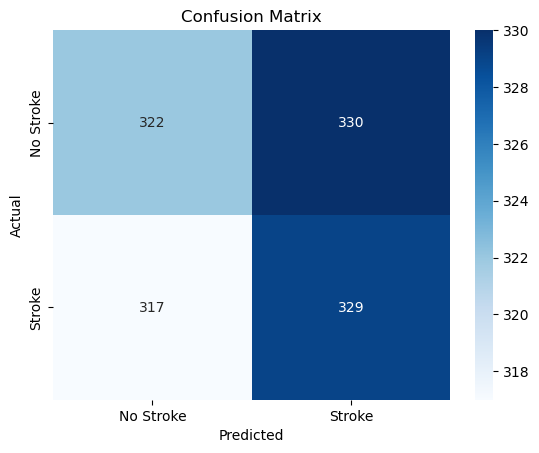

In [88]:
test_ratio = 0.2
train_data, test_data = train_test_split(df_binned, test_size=test_ratio, random_state=42)
print(f"The shape of the training data is: {train_data.shape} and the shape of the test_data is: {test_data.shape}")

tree_model.fit(train_data, estimator=BayesianEstimator, prior_type="BDeu")

predict_data = test_data.drop(columns = ['stroke'])
label_prediction = test_data['stroke']
data_pred = tree_model.predict(predict_data)
y_pred = data_pred['stroke']

accuracy, f1, prec, rec = accuracy_score(label_prediction, y_pred), f1_score(label_prediction, y_pred), precision_score(label_prediction, y_pred), recall_score(label_prediction, y_pred)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", prec)
print("Recall:", rec)

confusion = confusion_matrix(label_prediction, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

This model's performance is slightly worse than the others.

In the classification task, the Decision Tree classifier achieved an accuracy of 0.87, while all three Bayesian Network implementations performed poorly, with an accuracy score hovering around 0.5, equivalent to random chance.  
This difference highlights a crucial trade-off between different modeling paradigms. The Decision Tree, a discriminative model, excels at finding optimal decision boundaries by using continuous data directly. In contrast, the Bayesian Networks required the numerical variables to be discretized. This necessary preprocessing step, inherently causes a significant loss of information, preventing the BN from capturing the fine-grained relationships that are critical for high-accuracy classification in this dataset.  
Despite that, BNs can be leveraged as powerful and comprehensive tools for probabilistic reasoning, providing deep and interpretable insights into the problem domain that are simply unattainable with a ML model like a Decision Tree.  

Although the Hill Climb learned model achieves slightly higher accuracy, the difference is negligible. Consequently, the custom-designed Bayesian Network was chosen for inference due to its structure being grounded in well-established medical knowledge. This makes it more interpretable and suitable for understanding causal relationships and supporting transparent decision-making.

## Networks analysis
With pgmpy it is possible to analyse several properties of the networks. For example, we can take a look at the different independencies which hold in the network, ask for the local semantics (*any node in the network is independent of its non-descendents given its parents*) for a set of nodes or ask for the Markov blanket of a certain node.  
For conciseness, I'll analyze the custom model only.

In [72]:
nodes = df_binned.columns.tolist()
print(f'The total number of valid independence assertions is {len(custom_model.get_independencies().get_assertions())}.')
print()
print(f'Local semantics of the custom model:\n{custom_model.local_independencies(nodes)}')
print()
print('Checking Markov blankets')
for node in nodes:
    print(f'The Markov blanket of node {node} is {custom_model.get_markov_blanket(node)}')
print()

The total number of valid independence assertions is 22.

Local semantics of the custom model:
(gender ⟂ age, ever_married)
(age ⟂ gender)
(hypertension ⟂ Residence_type, ever_married, gender, work_type | smoking_status, age, bmi, avg_glucose_level)
(heart_disease ⟂ ever_married, Residence_type, work_type | age, smoking_status, avg_glucose_level, hypertension, bmi, gender)
(ever_married ⟂ avg_glucose_level, hypertension, work_type, Residence_type, bmi, heart_disease, smoking_status, gender | age)
(work_type ⟂ smoking_status, avg_glucose_level, hypertension, heart_disease, Residence_type, bmi, ever_married | age, gender)
(Residence_type ⟂ smoking_status, avg_glucose_level, hypertension, heart_disease, work_type, ever_married, bmi | age, gender)
(avg_glucose_level ⟂ Residence_type, ever_married, work_type | smoking_status, age, bmi, gender)
(bmi ⟂ Residence_type, smoking_status, ever_married, work_type | age, gender)
(smoking_status ⟂ Residence_type, ever_married, bmi, work_type | age, g

## Performing inference

In [13]:
inference = VariableElimination(custom_model)

### Predictive inference
The next questions are about predicting the outcome (stroke) based on a person's profile.

#### Persona-based risk profiling
I'm interesting in comparing the stroke risk for 2 different people (A and B).
* Persona A (High-Risk): A 75-year-old female who has never married, smokes, has hypertension, and a high BMI (e.g. 40).
* Persona B (Low-Risk): A 35-year-old male who has never smoked, has no hypertension, and a normal BMI (e.g. 21).  

This kind of experiment is a way to validate that the model has learnt sensible relationships.

In [75]:
print_bin_ranges('age', bin_edges_dict)
print_bin_ranges('bmi', bin_edges_dict)

Bin ranges for 'age':
  Bin 0: [10.00, 46.00)
  Bin 1: [46.00, 60.00)
  Bin 2: [60.00, 74.00)
  Bin 3: [74.00, 82.00)
Bin ranges for 'bmi':
  Bin 0: [11.50, 26.20)
  Bin 1: [26.20, 29.50)
  Bin 2: [29.50, 33.70)
  Bin 3: [33.70, 92.00)


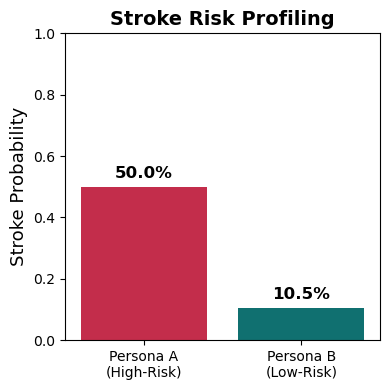

In [18]:
prob_stroke_A = inference.query(
    variables=['stroke'],
    evidence={
        'age': 3,
        'gender': 'Female',
        'smoking_status': 'smokes',
        'hypertension': 1,
        'bmi': 3
    }
)
prob_stroke_B = inference.query(
    variables=['stroke'],
    evidence={
        'age': 0,
        'gender': 'Male',        
        'smoking_status': 'never smoked',
        'hypertension': 0,
        'bmi': 0
    }
)

# Extract probabilities for stroke=1 from the query results
prob_A = prob_stroke_A.values[1]  # index 1 corresponds to stroke=1
prob_B = prob_stroke_B.values[1]

labels = ['Persona A\n(High-Risk)', 'Persona B\n(Low-Risk)']
probs = [prob_A, prob_B]

plt.figure(figsize=(4, 4))
sns.barplot(x=labels, y=probs, hue = labels, palette=['crimson', 'teal'])
plt.ylim(0, 1)
plt.ylabel('Stroke Probability', fontsize=13)
plt.title('Stroke Risk Profiling', fontsize=14, fontweight='bold')

# Annotate bars with percentage
for i, v in enumerate(probs):
    plt.text(i, v + 0.03, f"{v:.1%}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

As expected, the person with high risk has a 50% probability of having a stroke, while the low risk one has stroke chance of 10%.  
This demonstrates the model's ability to synthesize multiple pieces of evidence to produce a concrete, intuitive risk score.

#### Investigating a Single Factor's Impact
**Question:** "Holding all other factors unknown, how does the probability of stroke change as we move through the discretized age buckets?"  

This experiment isolates the effect of a single, powerful variable (age) and shows its direct marginal impact on the target.

Querying the model for each age bucket...
  - P(Stroke | Age='[10.00, 46.00)') = 0.1664
  - P(Stroke | Age='[46.00, 60.00)') = 0.4421
  - P(Stroke | Age='[60.00, 74.00)') = 0.5555
  - P(Stroke | Age='[74.00, 82.00)') = 0.6636


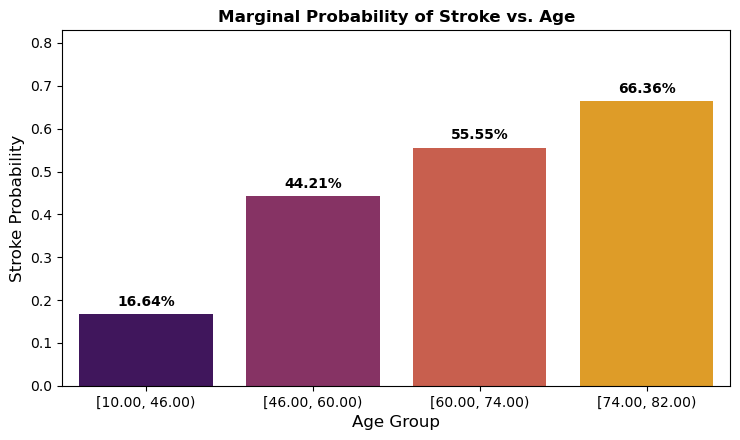

In [17]:
# Dictionary to store results: {readable_label: probability}
age_stroke_probabilities = {}

print("Querying the model for each age bucket...")
for i, age_state in enumerate(bin_edges_dict['age'].keys()):
    # Perform the query using the integer state (0, 1, 2, 3)
    query_result = inference.query(
        variables=['stroke'],
        evidence={'age': age_state}
    )
    
    # Extract the probability for the "stroke=1" state
    state_index = query_result.state_names['stroke'].index(1)
    prob = query_result.values[state_index]
    
    # Get the readable label for this state
    readable_label = bin_edges_dict['age'][age_state]
    
    # Store the result in our dictionary
    age_stroke_probabilities[readable_label] = prob
    print(f"  - P(Stroke | Age='{readable_label}') = {prob:.4f}")

# Extract data for plotting
labels = list(age_stroke_probabilities.keys())
probabilities = list(age_stroke_probabilities.values())

plt.figure(figsize=(7.5, 4.5))
barplot = sns.barplot(x=labels, y=probabilities, palette="inferno", hue=labels, legend=False)

plt.title('Marginal Probability of Stroke vs. Age', fontsize=12, fontweight='bold')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Stroke Probability', fontsize=12)
plt.ylim(0, max(probabilities) * 1.25) # Give some space for labels

# Add probability labels on top of each bar
for i in range(len(labels)):
    plt.text(i, probabilities[i] + (max(probabilities) * 0.02), f"{probabilities[i]:.2%}", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

As shown above, people aged between 10 and 46 years old have low change of getting a stroke (17%), while people aged from 46 to 60 have a stroke chance almost triple. When we go from 60 to 74 years of age the stroke probability increases of another 9%, while people aged 74 or more are at most risk of having a stroke, with a 66% probability.

### Diagnostic inference
The next question starts with the outcome and works backward to find more about the causes. This is a key strength of Bayesian Networks.

#### Identifying the "Smoking Gun" Risk Factor
According to the medical literature, hypertension is a leading cause of stroke. I want to investigate how much a "stroke" diagnosis should increase the belief that the person has hypertension. In other words, this experiment quantifies the diagnostic power of the outcome.  

**Question:** "Given that a patient has had a stroke, what is the probability that they also had pre-existing hypertension? How does this compare to the probability of hypertension in the general (non-stroke) population?"

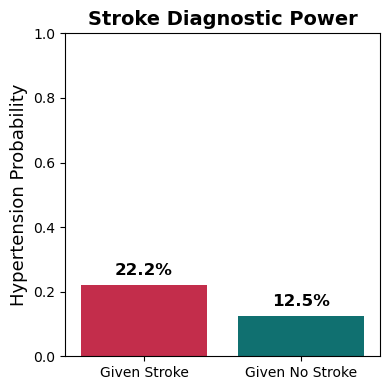

In [19]:
prob_hypertension_given_stroke = inference.query(
    variables=['hypertension'],
    evidence={'stroke': 1}
)
prob_hypertension_given_no_stroke = inference.query(
    variables=['hypertension'],
    evidence={'stroke': 0}
)
# Extract probabilities for hypertension=1 (i.e., has hypertension)
state_names = prob_hypertension_given_stroke.state_names['hypertension']
# Find the index corresponding to hypertension=1
idx_hypertension_1 = state_names.index(1) if 1 in state_names else 1

prob_stroke = prob_hypertension_given_stroke.values[idx_hypertension_1]
prob_no_stroke = prob_hypertension_given_no_stroke.values[idx_hypertension_1]

labels = ['Given Stroke', 'Given No Stroke']
probs = [prob_stroke, prob_no_stroke]

plt.figure(figsize=(4, 4))
sns.barplot(x=labels, y=probs, hue=labels, palette=['crimson', 'teal'])
plt.ylim(0, 1)
plt.ylabel('Hypertension Probability', fontsize=13)
plt.title('Stroke Diagnostic Power', fontsize=14, fontweight='bold')

for i, v in enumerate(probs):
    plt.text(i, v + 0.03, f"{v:.1%}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

A person that has had stroke has a 22% probability oh having a pre-existing hypertension, which is significantly higher compared to 12% of a patient who didn't have stroke.

### Intervention & "What-If" Scenarios
These are among the most powerful and interesting questions, as they explore the potential impact of changing behavior.

#### Quantifying the Benefit of Quitting Smoking
**Question:** "Let's consider a 50 year-old man with hypertension who currently smokes. What is his risk of stroke? What would his risk be if he quitted smoking (i.e. if he were in the formerly_smoked category instead), assuming all other factors remain the same?"  

This investigation directly models the potential benefit of a health intervention (quitting smoking), which can be extremely useful for doctors and public health officials.

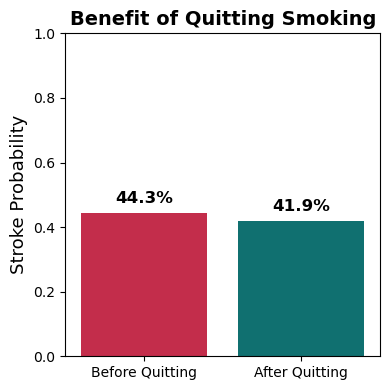

In [20]:
prob_stroke_before_quitting = inference.query(
    variables=['stroke'],
    evidence={
        'age': 1,
        'gender': 'Male',
        'hypertension': 1,
        'smoking_status': 'smokes'
        }
)
prob_stroke_after_quitting = inference.query(
    variables=['stroke'],
    evidence={
        'age': 1,
        'gender': 'Male',
        'hypertension': 1,
        'smoking_status': 'formerly smoked'
        }
)
# Extract probability of stroke=1 for both scenarios
state_names = prob_stroke_before_quitting.state_names['stroke']
idx_stroke_1 = state_names.index(1) if 1 in state_names else 1

prob_before = prob_stroke_before_quitting.values[idx_stroke_1]
prob_after = prob_stroke_after_quitting.values[idx_stroke_1]

labels = ['Before Quitting', 'After Quitting']
probs = [prob_before, prob_after]

plt.figure(figsize=(4, 4))
sns.barplot(x=labels, y=probs, hue=labels, palette=['crimson', 'teal'])
plt.ylim(0, 1)
plt.ylabel('Stroke Probability', fontsize=13)
plt.title('Benefit of Quitting Smoking', fontsize=14, fontweight='bold')

for i, v in enumerate(probs):
    plt.text(i, v + 0.03, f"{v:.1%}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Quitting smokink for a 50 year-old male with hypertension can reduce the risk of stroke just slightly (probability dropped from 44% to 42%).

#### Lifestyle Change Impact (BMI & Glucose)
Now I'm interested in quantifying the potential benefit of a positive lifestyle change, like following a healthy diet and doing physical activity, which can lead to lose weight and reduce the average glucose level in the blood.  

**Question:** "For a 55-year-old self-employed person with a high average glucose level (e.g. 200) and high BMI (e.g. 30), how much does their stroke risk decrease if they manage to lower their BMI and glucose levels into the normal range?"  
Similar to the smoking question, this shows the combined impact of lifestyle changes, which is highly actionable information.  
*An average glucose levels of 90 is considered normal, as well as a BMI of 23.

In [102]:
print_bin_ranges(col='age', dict=bin_edges_dict)
print_bin_ranges(col='avg_glucose_level', dict=bin_edges_dict)
print_bin_ranges(col='bmi', dict=bin_edges_dict)

Bin ranges for 'age':
  Bin 0: [10.00, 46.00)
  Bin 1: [46.00, 60.00)
  Bin 2: [60.00, 74.00)
  Bin 3: [74.00, 82.00)
Bin ranges for 'avg_glucose_level':
  Bin 0: [55.12, 78.64)
  Bin 1: [78.64, 98.47)
  Bin 2: [98.47, 171.60)
  Bin 3: [171.60, 271.74)
Bin ranges for 'bmi':
  Bin 0: [11.50, 26.20)
  Bin 1: [26.20, 29.50)
  Bin 2: [29.50, 33.70)
  Bin 3: [33.70, 92.00)


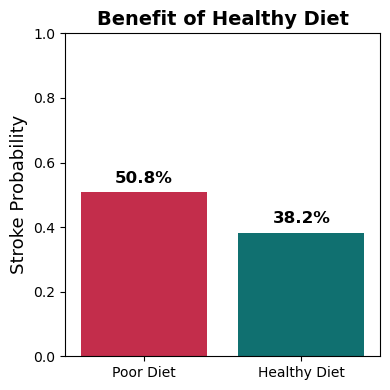

In [21]:
prob_stroke_poor_lifestyle = inference.query(
    variables=['stroke'],
    evidence={
        'age': 1,
        'work_type': 'Self-employed',
        'avg_glucose_level': 3,
        'bmi': 2
        }
)
prob_stroke_healthy_lifestyle = inference.query(
    variables=['stroke'],
    evidence={
        'age': 1,
        'work_type': 'Self-employed',
        'avg_glucose_level': 1,
        'bmi': 0
        }
)
# Extract probability of stroke=1 for both scenarios
state_names = prob_stroke_poor_lifestyle.state_names['stroke']
idx_stroke_1 = state_names.index(1) if 1 in state_names else 1

prob_poor = prob_stroke_poor_lifestyle.values[idx_stroke_1]
prob_healthy = prob_stroke_healthy_lifestyle.values[idx_stroke_1]

labels = ['Poor Diet', 'Healthy Diet']
probs = [prob_poor, prob_healthy]

plt.figure(figsize=(4, 4))
sns.barplot(x=labels, y=probs, hue=labels, palette=['crimson', 'teal'])
plt.ylim(0, 1)
plt.ylabel('Stroke Probability', fontsize=13)
plt.title('Benefit of Healthy Diet', fontsize=14, fontweight='bold')

for i, v in enumerate(probs):
    plt.text(i, v + 0.03, f"{v:.1%}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

For a 55-year-old self-employed person, adopting a healthier lifestyle can reduce the probability of stroke from 51% to 38%, proving that a positive lifestyle change has potential benefit, even for a 55 year-old.

### Explaining away
The next question explore a complex intercausal reasoning, showcasing a BN's capability of capturing complex interactions between multiple risk factors.

#### The "Explaining Away" Effect
**Question**: "A patient has had a stroke. The doctors' initial suspicion is he might have severe hypertension. Then, they measure his glucose levels for several days and discover he has abnormal average glucose levels. How does learning about the glucose levels change their belief about the patient having hypertension?"  

In many BNs, finding one strong cause for an effect can "explain away" the need for other causes. The probability of hypertension might actually decrease after the discover of high glucose levels, because the latter is a sufficient explanation for the stroke. This is a hallmark of true Bayesian reasoning.

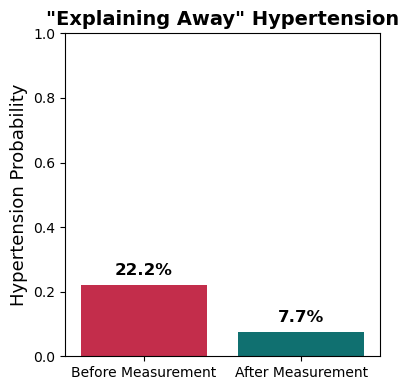

In [22]:
# prob_hypertension_before_measurements = inference.query(
#     variables=['hypertension'],
#     evidence={'stroke': 1}
# )     !!prob_hypertension_given_stroke gives the same probabilities!!
prob_hypertension_before_measurements = prob_hypertension_given_stroke
prob_hypertension_after_measurements = inference.query(
    variables=['hypertension'],
    evidence={
        'stroke': 1,
        'avg_glucose_level': 2
    }
)
# Extract probabilities for hypertension=1 (i.e., has hypertension)
state_names = prob_hypertension_before_measurements.state_names['hypertension']
idx_hypertension_1 = state_names.index(1) if 1 in state_names else 1

prob_before = prob_hypertension_before_measurements.values[idx_hypertension_1]
prob_after = prob_hypertension_after_measurements.values[idx_hypertension_1]

labels = ['Before Measurement', 'After Measurement']
probs = [prob_before, prob_after]

plt.figure(figsize=(4, 4))
sns.barplot(x=labels, y=probs, hue=labels, palette=['crimson', 'teal'])
plt.ylim(0, 1)
plt.ylabel('Hypertension Probability', fontsize=13)
plt.title('"Explaining Away" Hypertension', fontsize=14, fontweight='bold')

for i, v in enumerate(probs):
    plt.text(i, v + 0.03, f"{v:.1%}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

The probability of the patient having hypertension has indeed decreased from 22% to 8% after discovering that he has high glucose levels.